# Set Up

In [ ]:
%pwd

'/content'

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

FOLDERNAME = 'cse493g1/project'
PROJECT_PATH = f'/content/drive/MyDrive/{FOLDERNAME}'
%cd $PROJECT_PATH

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1OR_G1KW--WU6I4RMVItYt5BhiTf3RMiG/cse493g1/project


In [ ]:
# only run this for first time
!git clone https://github.com/zjc1421/VLAD.git

In [ ]:
%cd VLAD/

/content/drive/.shortcut-targets-by-id/1OR_G1KW--WU6I4RMVItYt5BhiTf3RMiG/cse493g1/project/VLAD


In [ ]:
!pip install -r requirements.txt

In [ ]:
# only run this for first time
%cd videos

/content/drive/MyDrive/cse493g1/project/VLAD/videos


In [ ]:
# only run this for first time
!tar -xf part1.tar.xz
!tar -xf part2.tar.xz

# Code

In [ ]:
import numpy as np
from transformers import CLIPProcessor, CLIPModel
import pytorchvideo.models.hub as modelsa


In [ ]:
import numpy as np
import torch
import utils
import vlad
import attack


In [ ]:
device = 'cuda'
ar_model = models.csn_r101(True)
ar_model = ar_model.eval().to(device)
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_model.eval().to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


In [ ]:
label_names = None
with open('kinetics-labels.txt') as file:
	label_names = [line.rstrip() for line in file]

video_names = ['vid1.npy', 'vid2.npy', 'vid3.npy', 'vid4.npy', 'vid5.npy', 'vid6.npy', 'vid7.npy', 'vid8.npy']
scores_clean_kl = []
scores_attacked_kl = []
scores_clean_chi = []
scores_attacked_chi = []
scores_clean_hell = []
scores_attacked_hell = []
scores_clean_bhat = []
scores_attacked_bhat = []
scores_clean_tvd = []
scores_attacked_tvd = []



Video shape after attack: torch.Size([1, 3, 32, 224, 224])


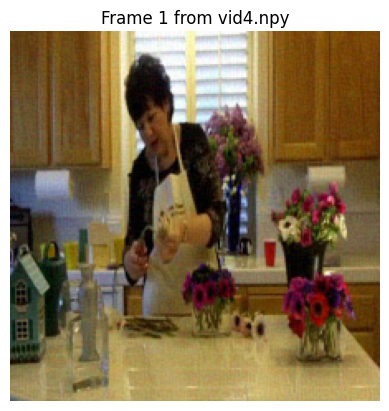

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import utils
import attack
import torch  # If you're using PyTorch tensors

# Load and process video
video_name = 'vid4.npy'
video = np.load(f'videos/{video_name}')
video = utils.process_video(video)
video = attack.pgd_attack(ar_model, video, eps=0.03)

# Remove the batch dimension (squeeze it)
print(f"Video shape after attack: {video.shape}")
video = video.squeeze(0)  # Remove the batch dimension, shape becomes [3, 32, 224, 224]

# Loop through the frames
for frame_idx in range(video.shape[1]):  # Iterate over the frames (32)
    frame = video[:, frame_idx, :, :]  # Select a single frame, shape [3, 224, 224]
    frame = frame.permute(1, 2, 0)  # Convert [C, H, W] to [H, W, C]

    # Convert to NumPy and scale for visualization
    frame = frame.detach().cpu().numpy()  # Convert to NumPy array
    frame = (frame * 255).astype('uint8')  # Scale pixel values to [0, 255] if normalized

    # Display the frame
    plt.imshow(frame)
    plt.title(f"Frame {frame_idx + 1} from {video_name}")
    plt.axis('off')
    plt.show()

    # Optionally break after displaying one or a few frames
    if frame_idx == 0:  # Display only the first frame
        break


In [ ]:
# 'kl' for KL divergence (default)
# 'chi' for Chi-Squared Divergence
# 'hell' for Hellinger Distance
# 'bhat' for Bhattacharyya Distance
# 'tvd' for Total Variation Distance
for (i, video_name) in enumerate(video_names):
    video = np.load('videos/{}'.format(video_name))
    video = utils.process_video(video)

    with torch.no_grad():
        score_clean_kl = vlad.vlad_score(video, ar_model, clip_model, clip_processor, label_names, distance_metric='kl')
        score_clean_chi = vlad.vlad_score(video, ar_model, clip_model, clip_processor, label_names, distance_metric='chi')
        score_clean_hell = vlad.vlad_score(video, ar_model, clip_model, clip_processor, label_names, distance_metric='hell')
        score_clean_bhat = vlad.vlad_score(video, ar_model, clip_model, clip_processor, label_names, distance_metric='bhat')
        score_clean_tvd = vlad.vlad_score(video, ar_model, clip_model, clip_processor, label_names, distance_metric='tvd')

    video = attack.pgd_attack(ar_model, video, eps=0.03)

    with torch.no_grad():
        score_attacked_kl = vlad.vlad_score(video, ar_model, clip_model, clip_processor, label_names, distance_metric='kl')
        score_attacked_chi = vlad.vlad_score(video, ar_model, clip_model, clip_processor, label_names, distance_metric='chi')
        score_attacked_hell = vlad.vlad_score(video, ar_model, clip_model, clip_processor, label_names, distance_metric='hell')
        score_attacked_bhat = vlad.vlad_score(video, ar_model, clip_model, clip_processor, label_names, distance_metric='bhat')
        score_attacked_tvd = vlad.vlad_score(video, ar_model, clip_model, clip_processor, label_names, distance_metric='tvd')


    scores_clean_kl.append(score_clean_kl)
    scores_attacked_kl.append(score_attacked_kl)
    scores_clean_chi.append(score_clean_chi)
    scores_attacked_chi.append(score_attacked_chi)
    scores_clean_hell.append(score_clean_hell)
    scores_attacked_hell.append(score_attacked_hell)
    scores_clean_bhat.append(score_clean_bhat)
    scores_attacked_bhat.append(score_attacked_bhat)
    scores_clean_tvd.append(score_clean_tvd)
    scores_attacked_tvd.append(score_attacked_tvd)

    torch.cuda.empty_cache()

    # Debug memory usage
    # print(torch.cuda.memory_allocated() / 1024**2, "MB allocated")
    # print(torch.cuda.memory_reserved() / 1024**2, "MB reserved")


***************************
VLAD Score calculation
ar_model predicted label: tensor(7, device='cuda:0')
clip predictions: [('arranging flowers', 0.9888105392456055), ('watering plants', 0.002129401545971632), ('tossing salad', 0.001429706229828298), ('setting table', 0.0006538176094181836), ('spray painting', 0.0005382432136684656), ('picking fruit', 0.0004890334093943238), ('blowing glass', 0.0002213528350694105), ('planting trees', 0.00021535374980885535), ('sharpening knives', 0.0002136889088433236), ('cutting pineapple', 0.00019900157349184155), ('barbequing', 0.00017514133651275188), ('feeding birds', 0.00016450052498839796), ('garbage collecting', 0.00016210382455028594), ('unboxing', 0.00014936721709091216), ('sniffing', 0.00013282030704431236), ('sneezing', 0.0001268111082026735), ('grinding meat', 0.00012431594950612634), ('bee keeping', 0.00012419416452758014), ('changing wheel', 0.00012114332639612257), ('tasting food', 0.00012042614980600774), ('frying vegetables', 0.000118

In [ ]:
print()
print('Report:')
for (i, video_name) in enumerate(video_names):
	print('VLAD Scores (KL) for {} -> clean: {}, attacked: {}'.format(video_name, scores_clean_kl[i], scores_attacked_kl[i]))
	print('VLAD Scores (Chi) for {} -> clean: {}, attacked: {}'.format(video_name, scores_clean_chi[i], scores_attacked_chi[i]))
	print('VLAD Scores (Hell) for {} -> clean: {}, attacked: {}'.format(video_name, scores_clean_hell[i], scores_attacked_hell[i]))
	print('VLAD Scores (Bhat) for {} -> clean: {}, attacked: {}'.format(video_name, scores_clean_bhat[i], scores_attacked_bhat[i]))
	print('VLAD Scores (TVD) for {} -> clean: {}, attacked: {}'.format(video_name, scores_clean_tvd[i], scores_attacked_tvd[i]))



Report:
VLAD Scores (KL) for vid1.npy -> clean: 0.03403858467936516, attacked: 15.47034740447998
VLAD Scores (Chi) for vid1.npy -> clean: 8.648956209421158, attacked: 3191356.59375
VLAD Scores (Hell) for vid1.npy -> clean: 0.06417444818891023, attacked: 0.9988571635670148
VLAD Scores (Bhat) for vid1.npy -> clean: 0.004126767162233591, attacked: 6.081632137298584
VLAD Scores (TVD) for vid1.npy -> clean: 0.009463528171181679, attacked: 0.9998545050621033
VLAD Scores (KL) for vid2.npy -> clean: 0.4129575788974762, attacked: 26.766990661621094
VLAD Scores (Chi) for vid2.npy -> clean: 25.431523323059082, attacked: 270028005693.21875
VLAD Scores (Hell) for vid2.npy -> clean: 0.27015447115239893, attacked: 0.9993016905854915
VLAD Scores (Bhat) for vid2.npy -> clean: 0.07578391581773758, attacked: 6.574033737182617
VLAD Scores (TVD) for vid2.npy -> clean: 0.10120896995067596, attacked: 0.9998369812965393
VLAD Scores (KL) for vid3.npy -> clean: 0.44774216413497925, attacked: 27.507585525512695

In [ ]:
# Ensure all values are Python scalars
scores_clean_kl = [score.cpu().item() if isinstance(score, torch.Tensor) else score for score in scores_clean_kl]
scores_attacked_kl = [score.cpu().item() if isinstance(score, torch.Tensor) else score for score in scores_attacked_kl]
scores_clean_chi = [score.cpu().item() if isinstance(score, torch.Tensor) else score for score in scores_clean_chi]
scores_attacked_chi = [score.cpu().item() if isinstance(score, torch.Tensor) else score for score in scores_attacked_chi]
scores_clean_hell = [score.cpu().item() if isinstance(score, torch.Tensor) else score for score in scores_clean_hell]
scores_attacked_hell = [score.cpu().item() if isinstance(score, torch.Tensor) else score for score in scores_attacked_hell]
scores_clean_bhat = [score.cpu().item() if isinstance(score, torch.Tensor) else score for score in scores_clean_bhat]
scores_attacked_bhat = [score.cpu().item() if isinstance(score, torch.Tensor) else score for score in scores_attacked_bhat]
scores_clean_tvd = [score.cpu().item() if isinstance(score, torch.Tensor) else score for score in scores_clean_tvd]
scores_attacked_tvd = [score.cpu().item() if isinstance(score, torch.Tensor) else score for score in scores_attacked_tvd]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


sorted_scores = sorted(scores_clean_kl)


theta = 70
K = len(sorted_scores)
index = int((K * theta) / 100)

threshold = sorted_scores[index]
print(f"The threshold ({theta}th percentile) is: {threshold}")


The threshold (70th percentile) is: 0.44774216413497925


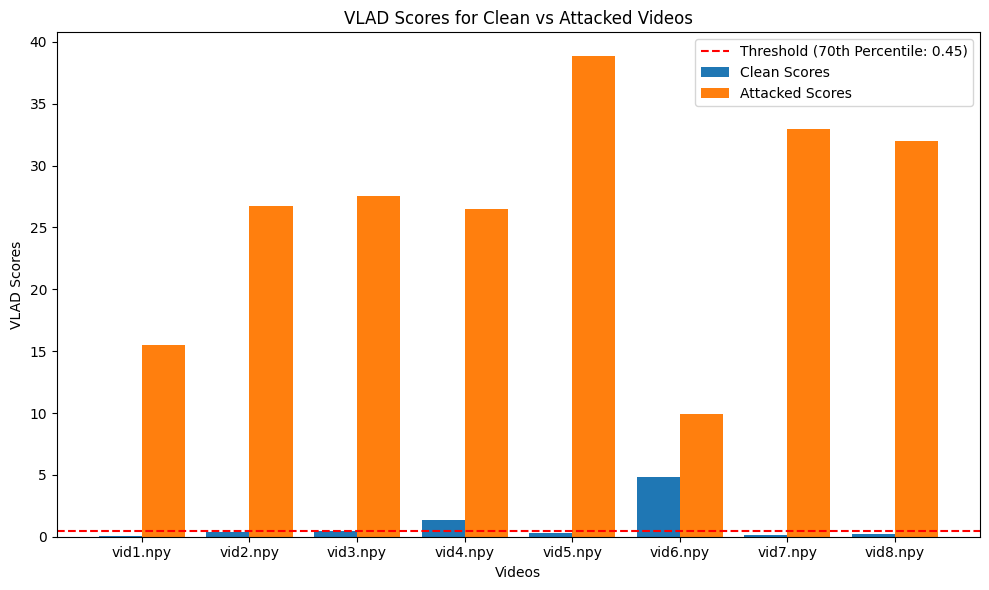

In [ ]:
x = np.arange(len(video_names))
width = 0.4

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, scores_clean_kl, width, label='Clean Scores')
ax.bar(x + width/2, scores_attacked_kl, width, label='Attacked Scores')
ax.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({theta}th Percentile: {threshold:.2f})')

ax.set_xlabel('Videos')
ax.set_ylabel('VLAD Scores')
ax.set_title('VLAD Scores for Clean vs Attacked Videos')
ax.set_xticks(x)
ax.set_xticklabels(video_names)
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
sorted_scores = sorted(scores_clean_hell)

theta = 70  # Percentile
K = len(sorted_scores)
index = int((K * theta) / 100)

threshold = sorted_scores[index]
print(f"The threshold ({theta}th percentile) is: {threshold}")

The threshold (70th percentile) is: 0.40678893755705375


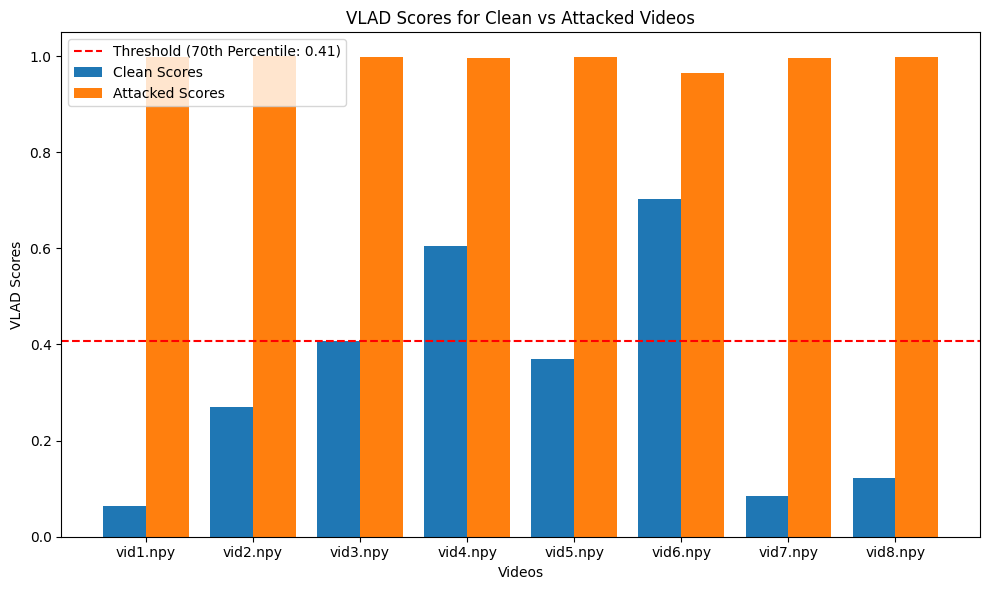

In [ ]:
x = np.arange(len(video_names))
width = 0.4

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, scores_clean_hell, width, label='Clean Scores')
ax.bar(x + width/2, scores_attacked_hell, width, label='Attacked Scores')
ax.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({theta}th Percentile: {threshold:.2f})')

# Adding labels and title
ax.set_xlabel('Videos')
ax.set_ylabel('VLAD Scores')
ax.set_title('VLAD Scores for Clean vs Attacked Videos')
ax.set_xticks(x)
ax.set_xticklabels(video_names)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
sorted_scores = sorted(scores_clean_bhat)

theta = 70  # Percentile
K = len(sorted_scores)
index = int((K * theta) / 100)

threshold = sorted_scores[index]
print(f"The threshold ({theta}th percentile) is: {threshold}")

The threshold (70th percentile) is: 0.18089516460895538


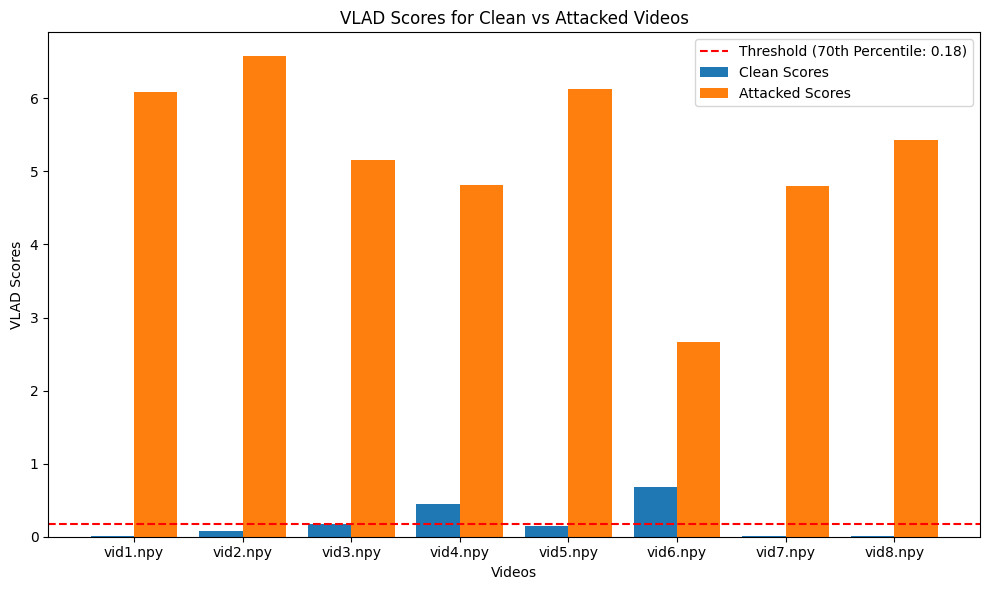

In [ ]:
x = np.arange(len(video_names))
width = 0.4

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, scores_clean_bhat, width, label='Clean Scores')
ax.bar(x + width/2, scores_attacked_bhat, width, label='Attacked Scores')
ax.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({theta}th Percentile: {threshold:.2f})')

# Adding labels and title
ax.set_xlabel('Videos')
ax.set_ylabel('VLAD Scores')
ax.set_title('VLAD Scores for Clean vs Attacked Videos')
ax.set_xticks(x)
ax.set_xticklabels(video_names)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
sorted_scores = sorted(scores_clean_tvd)

theta = 70  # Percentile
K = len(sorted_scores)
index = int((K * theta) / 100)

threshold = sorted_scores[index]
print(f"The threshold ({theta}th percentile) is: {threshold}")

The threshold (70th percentile) is: 0.3315582275390625


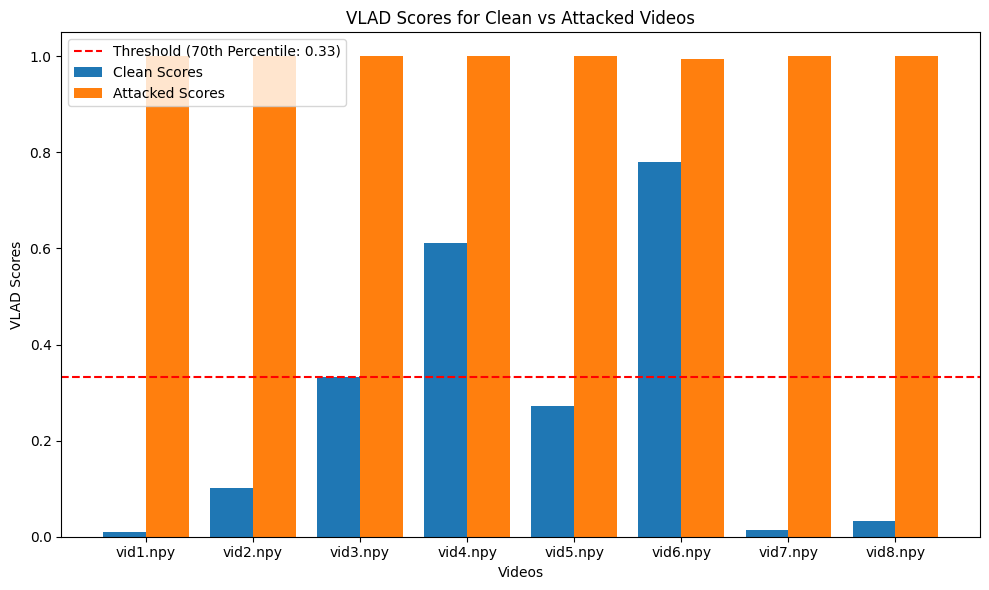

In [ ]:
x = np.arange(len(video_names))
width = 0.4

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, scores_clean_tvd, width, label='Clean Scores')
ax.bar(x + width/2, scores_attacked_tvd, width, label='Attacked Scores')
ax.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold ({theta}th Percentile: {threshold:.2f})')

# Adding labels and title
ax.set_xlabel('Videos')
ax.set_ylabel('VLAD Scores')
ax.set_title('VLAD Scores for Clean vs Attacked Videos')
ax.set_xticks(x)
ax.set_xticklabels(video_names)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

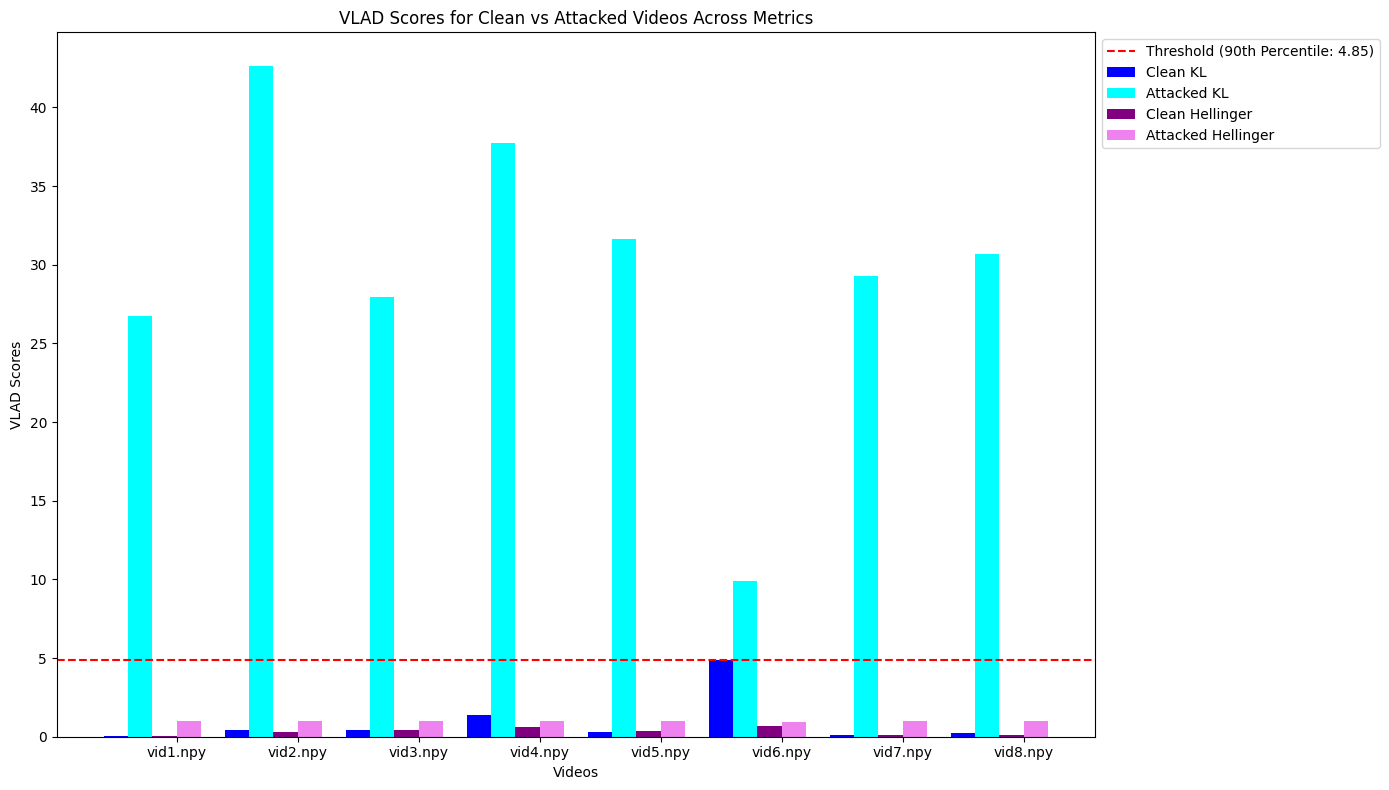

In [ ]:
# ignore this cell

# Ensure all values are Python scalars
scores_clean_kl = [score.cpu().item() if isinstance(score, torch.Tensor) else score for score in scores_clean_kl]
scores_attacked_kl = [score.cpu().item() if isinstance(score, torch.Tensor) else score for score in scores_attacked_kl]
scores_clean_chi = [score.cpu().item() if isinstance(score, torch.Tensor) else score for score in scores_clean_chi]
scores_attacked_chi = [score.cpu().item() if isinstance(score, torch.Tensor) else score for score in scores_attacked_chi]
scores_clean_hell = [score.cpu().item() if isinstance(score, torch.Tensor) else score for score in scores_clean_hell]
scores_attacked_hell = [score.cpu().item() if isinstance(score, torch.Tensor) else score for score in scores_attacked_hell]

# # Scale down attacked Chi scores for plotting
# scaled_attacked_chi = [value / 1e12 for value in scores_attacked_chi]  # Adjust scale factor if needed

# Configuration for plotting
x = np.arange(len(video_names))
width = 0.2

fig, ax = plt.subplots(figsize=(14, 8))

# Bar plots for each metric
ax.bar(x - width, scores_clean_kl, width, label='Clean KL', color='blue')
ax.bar(x, scores_attacked_kl, width, label='Attacked KL', color='cyan')
ax.bar(x + width, scores_clean_hell, width, label='Clean Hellinger', color='purple')
ax.bar(x + 2 * width, scores_attacked_hell, width, label='Attacked Hellinger', color='violet')
# ax.bar(x + width, scores_clean_chi, width, label='Clean Chi', color='green')
# ax.bar(x + 2 * width, scaled_attacked_chi, width, label='Attacked Chi (scaled)', color='lime')
# ax.bar(x + 3 * width, scores_clean_hell, width, label='Clean Hellinger', color='purple')
# ax.bar(x + 4 * width, scores_attacked_hell, width, label='Attacked Hellinger', color='violet')

sorted_scores = sorted(scores_clean_kl)
theta = 90
index = int((len(sorted_scores) * theta) / 100)
threshold = sorted_scores[index]
ax.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold (90th Percentile: {threshold:.2f})')

ax.set_xlabel('Videos')
ax.set_ylabel('VLAD Scores')
ax.set_title('VLAD Scores for Clean vs Attacked Videos Across Metrics')
ax.set_xticks(x + 1.5 * width)
ax.set_xticklabels(video_names)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

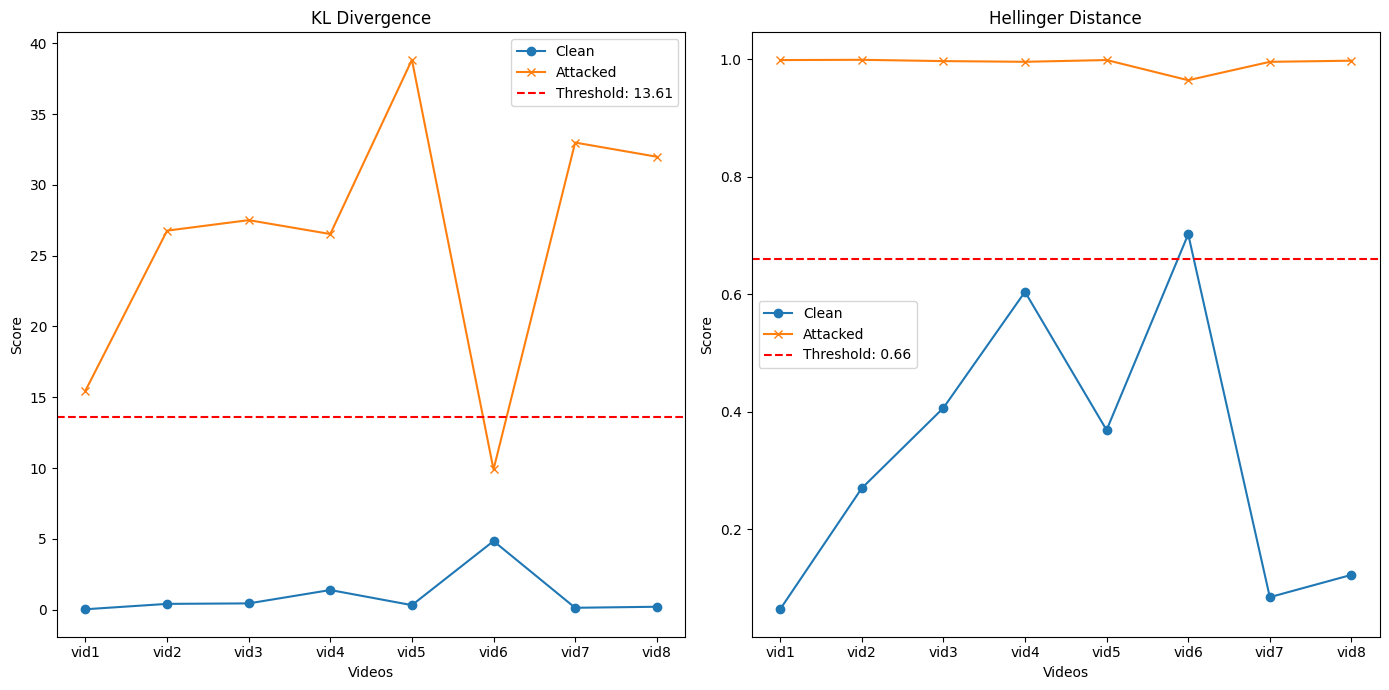

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

videos = ['vid1', 'vid2', 'vid3', 'vid4', 'vid5', 'vid6', 'vid7', 'vid8']
kl_clean = [0.03403858467936516, 0.4129575788974762, 0.44774216413497925, 1.3919075727462769, 0.32381847500801086, 4.847530841827393, 0.13753391802310944, 0.21061155200004578]
kl_attacked = [15.47034740447998, 26.766990661621094, 27.507585525512695, 26.527706146240234, 38.8288459777832, 9.903602600097656, 32.9853630065918, 31.985288619995117]
hell_clean = [0.06417444818891023, 0.27015447115239893, 0.40678893755705375, 0.6044041900104096, 0.36913573206193473, 0.7023823294971522, 0.0847563468582599, 0.12270703690287592]
hell_attacked = [0.9988571635670148, 0.9993016905854915, 0.9970983359985803, 0.9959100155794018, 0.9989018779580097, 0.9645537232554405, 0.9958559633818973, 0.9977970105017794]

kl_threshold = np.mean([np.mean(kl_clean), np.mean(kl_attacked)])
hell_threshold = np.mean([np.mean(hell_clean), np.mean(hell_attacked)])

plt.figure(figsize=(14, 7))

# KL Divergence
plt.subplot(1, 2, 1)
plt.plot(videos, kl_clean, label="Clean", marker='o')
plt.plot(videos, kl_attacked, label="Attacked", marker='x')
plt.axhline(y=kl_threshold, color='r', linestyle='--', label=f"Threshold: {kl_threshold:.2f}")
plt.title("KL Divergence")
plt.xlabel("Videos")
plt.ylabel("Score")
plt.legend()

# Hellinger Distance
plt.subplot(1, 2, 2)
plt.plot(videos, hell_clean, label="Clean", marker='o')
plt.plot(videos, hell_attacked, label="Attacked", marker='x')
plt.axhline(y=hell_threshold, color='r', linestyle='--', label=f"Threshold: {hell_threshold:.2f}")
plt.title("Hellinger Distance")
plt.xlabel("Videos")
plt.ylabel("Score")
plt.legend()

plt.tight_layout()
plt.show()
